Ways of solving for the coefficients

**1. matrix inversion**

**2. Scikit's linear regression class**

**3. gradient descent**

#### Goal: create a formula for predicting the sale price of any house in Cleveland

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Some basic functions like reading of data, creating regression equation based on coefficients, evaluation function

In [125]:
# create an function to read the excel file
def read_excel_data(infilename):
    df = pd.read_excel(infilename, index_col=0)

    n, d = df.values.shape
    d = d - 1 # The price column doesn't count

    X = df.values[:,:-1] # take all inputs features
    labels = df.columns[:-1]
    Y = df['price'].values
    X = np.hstack([np.ones((n,1)), X]) # add extra coefficient of one's to the features
    
    return X, Y, labels

In [126]:
# defining of the prediction formula
def format_prediction(B, labels):
    ## Your code here
    string = "predicted price = "
    for i in range(len(B)):
        if i == 0:
            string += f"${B[i]:,.2f} + "
        else:
            string += f"(${B[i]:,.2f} * {labels[i-1]}) + "

    pred_string = string[:-3]
    return pred_string

In [127]:
# defining the evaluation matrices: R2
# Return the R2 score for coefficients B
# Given inputs X and outputs Y
def score(B, X, Y):
    y_hat = np.dot(X, B)
    sum_square_yhat = sum((Y - y_hat) ** 2)

    y_base = np.mean(Y)
    sum_square_ybase = sum((Y - y_base) ** 2)
    R2 = round(1 - (sum_square_yhat / sum_square_ybase), 6)
    return R2

### 1. Using Matrix Inversion

In [128]:
# Read the spreadsheet
X, Y, labels = read_excel_data("properties.xlsx")

In [136]:
n, d = X.shape
print(f"Read {n} rows, {d - 1} features from 'properties.xlsx'")

Read 519 rows, 5 features from 'properties.xlsx'


In [130]:
# Find the coefficients for the linear regression
B = np.linalg.inv(X.T @ X) @ X.T @ Y

**GET THE PREDICTION EQUATION**

In [131]:
# print the equation
print(format_prediction(B, labels))

predicted price = $32,362.85 + ($85.61 * sqft_hvac) + ($2.73 * sqft_yard) + ($59,195.07 * bedrooms) + ($9,599.24 * bathrooms) + ($-17,421.84 * miles_to_school)


In [143]:
# Evaluation
# Get the R2 score (1 is perfect, 0 as bad as just using the mean)
R2 = score(B, X, Y)
print(f"R2 = {R2:f}")

R2 = 0.875699


### 2. Using Scikit-Learn

In [132]:
from sklearn.linear_model import LinearRegression

In [133]:
X, Y, labels = read_excel_data("properties.xlsx")

In [135]:
n, d = X.shape
print(f"Read {n} rows, {d-1} features from 'properties.xlsx'.")

Read 519 rows, 5 features from 'properties.xlsx'.


In [137]:
# Don't need the intercept added -- X has column of 1s
lin_reg = LinearRegression(fit_intercept=False)

In [138]:
# Fit the model
lin_reg.fit(X, Y)

LinearRegression(fit_intercept=False)

**GET THE PREDICTION EQUATION**

In [140]:
print(format_prediction(lin_reg.coef_, labels))

predicted price = $32,362.85 + ($85.61 * sqft_hvac) + ($2.73 * sqft_yard) + ($59,195.07 * bedrooms) + ($9,599.24 * bathrooms) + ($-17,421.84 * miles_to_school)


In [141]:
# Evaluation
# Get the R2 score (1 is perfect, 0 as bad as just using the mean)
R2 = lin_reg.score(X, Y)
print(f"R2 = {R2:f}")

R2 = 0.875699


### 3. Using Gradient Descent to converge upon the formula

In [156]:
# Learning rate
t = 0.001

# Limit interations
max_steps = 1000

X, Y, labels = read_excel_data("properties.xlsx")
X_org = X[::]

n, d = X.shape
print(f"Read {n} rows, {d - 1} features from 'properties.xlsx'.")

Read 519 rows, 5 features from 'properties.xlsx'.


In [157]:
# The features in properties.xlsx are on very different scales (2 bathrooms vs 50,000 square foot yards). 
# As a result, converging would take a very, very long time if you don’t first standardize the features.
# Standardize X to be X'

# Get the mean and standard deviation for each column
mu = np.mean(X[:, 1:], axis=0)
sigma = np.std(X[:, 1:], axis=0)

# No need to mess with the first column (the 1s)
X = X[:, 1:]

Xp = (X - mu) / sigma
Xp = np.hstack((np.ones((n, 1)), Xp)) 

In [158]:
# First guess for B is "all coefficents are zero"
B = np.zeros(d)  
tolerance = 0.01

# a numpy array to record avg error for each step
errors = np.zeros(max_steps) 

# gradient descent algorithm
# 1. Calculate the gradient
# 2. Update your guess. (Multiply the gradient by -0.001 and add to the last guess.)
# 3. Compute and record the new mean squared error

for i in range(max_steps):
    # Compute the gradient
    predictions = Xp.dot(B)
    diff = np.subtract(predictions, Y)
    gradient = Xp.T.dot(diff)

    # Compute a new B (use `t`)
    B = B - np.dot(t, gradient)
    # Figure out the average squared error using the new B
    predictions = Xp.dot(B)
    diff = np.subtract(predictions, Y)

    sqrErrors = np.square(diff)
    J = (1 / n) * np.sum(sqrErrors)

    # Store it in `errors``
    errors[i] = J

    if i > 0 and abs(errors[i - 1] - J) <= tolerance:
        break

print(f"Took {i} iterations to converge")

Took 377 iterations to converge


In [150]:
# "Unstandardize" the coefficients
B_org = np.zeros(6)
n = np.multiply(B[1:], mu)
n = np.divide(n, sigma)
b0_extra = sum(n)
B_org[0] = B[0] - b0_extra

B_org[1:] = B[1:] / sigma
B = B_org

In [151]:
print(format_prediction(B, labels))

predicted price = $32,362.84 + ($85.61 * sqft_hvac) + ($2.73 * sqft_yard) + ($59,195.83 * bedrooms) + ($9,599.12 * bathrooms) + ($-17,421.84 * miles_to_school)


In [153]:
X = X_org
# Get the R2 score
R2 = score(B, X, Y)
print(f"R2 = {R2:f}")

R2 = 0.875699


Text(0.5, 1.0, 'Convergence')

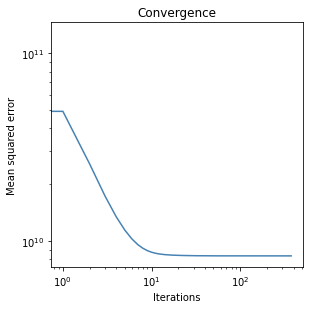

In [154]:
# Draw a graph
fig1 = plt.figure(1, (4.5, 4.5))
plt.plot(range(0, 377), errors[:377], color="steelblue")

plt.ticklabel_format(useMathText=True)
plt.xlabel("Iterations")
plt.ylabel("Mean squared error")
plt.loglog()
plt.title("Convergence")

### We can see that coefficients and R2 score from all 3 methods (Matrix Inversion, Scikit-Learn's LinearRegression and gradient descent covergence) are same 🥳